<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 2: </span>EDA and Feature Transformation</h1>
<hr>

### In this module we will:
<br><hr id="toc">
1. [Import the reduced_dim dataset we saved in Module1](#import)
2. [Plot feature correlations and distributions](#correlations)
3. [Perform Box Cox transformation to make distributions as close to normal as possibble](#box cox)
4. [Observe normal probability plots before and after transformation](#normality plots)
5. [Save train and test sets](#save datasets)

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

#Data Visualization
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#from ggplot import *
import seaborn as sns

import scipy.stats as stats # the module for probability plots
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

<br id="import">
## Import Data Set From Module1
<hr>

In [2]:
#import features, target variable (Win_Loss), plus Sector, Sym, PctRet that we might need later for performance analytics
reduced_dim = pd.read_csv('reduced_dim.csv')

In [3]:
reduced_dim.Date = pd.to_datetime(reduced_dim.Date)

In [4]:
reduced_dim.head()

,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,PctD3,VS2,PV13,VR1,Lrd_DV,Sector,Sym,Win_Loss,PctRet,Date
0,0.566845,0.012197,0.475936,-0.003963,1.201205,1.218531,0.009434,0.358289,0.349497,0.096541,0.270306,194.5,FX,AD,1,0.004752,2004-03-31
1,0.513514,0.095890,0.130631,0.000789,0.904435,1.278744,0.149123,-0.004505,0.443065,0.008476,0.565409,150.4,FX,AD,1,0.001344,2004-04-06
2,0.412429,0.020684,0.129944,0.002133,0.659084,0.811833,0.589041,0.395480,0.147982,0.202630,0.750645,257.0,FX,AD,1,0.006954,2004-04-07
3,0.425856,0.032548,-0.311787,0.018749,1.225677,1.179071,0.455357,-0.163498,0.064760,0.044511,2.091955,838.2,FX,AD,0,-0.005148,2004-04-21
4,0.418033,0.093742,-0.159836,0.013601,1.142937,1.068175,0.647059,-0.118852,0.444562,0.013363,0.276042,361.5,FX,AD,0,-0.004068,2004-04-22


In [5]:
#extract features only
feats = reduced_dim.drop(['Sector','Sym','Win_Loss','PctRet','Date'],axis=1)
feats.head()

,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,PctD3,VS2,PV13,VR1,Lrd_DV
0,0.566845,0.012197,0.475936,-0.003963,1.201205,1.218531,0.009434,0.358289,0.349497,0.096541,0.270306,194.5
1,0.513514,0.095890,0.130631,0.000789,0.904435,1.278744,0.149123,-0.004505,0.443065,0.008476,0.565409,150.4
2,0.412429,0.020684,0.129944,0.002133,0.659084,0.811833,0.589041,0.395480,0.147982,0.202630,0.750645,257.0
3,0.425856,0.032548,-0.311787,0.018749,1.225677,1.179071,0.455357,-0.163498,0.064760,0.044511,2.091955,838.2
4,0.418033,0.093742,-0.159836,0.013601,1.142937,1.068175,0.647059,-0.118852,0.444562,0.013363,0.276042,361.5


<hr style="border-color:royalblue;background-color:royalblue;height:1px;">
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="hyperparameters">
## Feature correlations and histograms
<hr>

<br id="correlations">


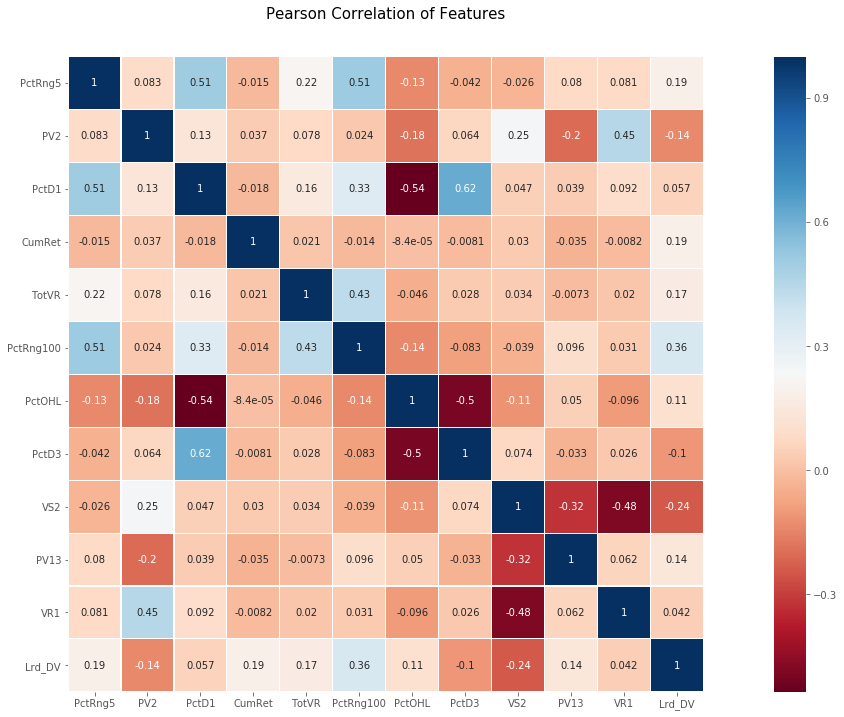

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(feats.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.tight_layout();

#### PctD3 shows high correlation to PctD1. Since it is the only feature that also showed non linear relationship to our target, we choose to remove it at this point.

In [7]:
reduced_dim1 = feats.drop(['PctD3'],axis=1)
reduced_dim1.head()

,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,VS2,PV13,VR1,Lrd_DV
0,0.566845,0.012197,0.475936,-0.003963,1.201205,1.218531,0.009434,0.349497,0.096541,0.270306,194.5
1,0.513514,0.095890,0.130631,0.000789,0.904435,1.278744,0.149123,0.443065,0.008476,0.565409,150.4
2,0.412429,0.020684,0.129944,0.002133,0.659084,0.811833,0.589041,0.147982,0.202630,0.750645,257.0
3,0.425856,0.032548,-0.311787,0.018749,1.225677,1.179071,0.455357,0.064760,0.044511,2.091955,838.2
4,0.418033,0.093742,-0.159836,0.013601,1.142937,1.068175,0.647059,0.444562,0.013363,0.276042,361.5


<hr>
#### Remaining 11 features and target variable Win_Loss plus Date, Sector, and PctRet columns gives us our analytical base table (ABT) that we'll  use later for modeling and performance analytics
<hr>

In [8]:
abt = pd.concat([reduced_dim[['Date','Sector','Sym','Win_Loss','PctRet']], reduced_dim1], axis=1)
abt.head()
abt.set_index('Date',inplace=True)
split_date = pd.datetime(2013,12,31)
train = abt.loc[abt.index<= split_date] 
test = abt.loc[abt.index> split_date]
train.head()

,Sector,Sym,Win_Loss,PctRet,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,VS2,PV13,VR1,Lrd_DV
Date,,,,,,,,,,,,,,,
2004-03-31,FX,AD,1,0.004752,0.566845,0.012197,0.475936,-0.003963,1.201205,1.218531,0.009434,0.349497,0.096541,0.270306,194.5
2004-04-06,FX,AD,1,0.001344,0.513514,0.095890,0.130631,0.000789,0.904435,1.278744,0.149123,0.443065,0.008476,0.565409,150.4
2004-04-07,FX,AD,1,0.006954,0.412429,0.020684,0.129944,0.002133,0.659084,0.811833,0.589041,0.147982,0.202630,0.750645,257.0
2004-04-21,FX,AD,0,-0.005148,0.425856,0.032548,-0.311787,0.018749,1.225677,1.179071,0.455357,0.064760,0.044511,2.091955,838.2
2004-04-22,FX,AD,0,-0.004068,0.418033,0.093742,-0.159836,0.013601,1.142937,1.068175,0.647059,0.444562,0.013363,0.276042,361.5


#### We need to split into train/test sets again before any transformations
<hr>

In [9]:
X_train = train.drop(['Sector','Sym','Win_Loss','PctRet'], axis=1)
y_train = train['Win_Loss']
 
X_test = test.drop(['Sector','Sym','Win_Loss','PctRet'], axis=1)
y_test = test['Win_Loss']

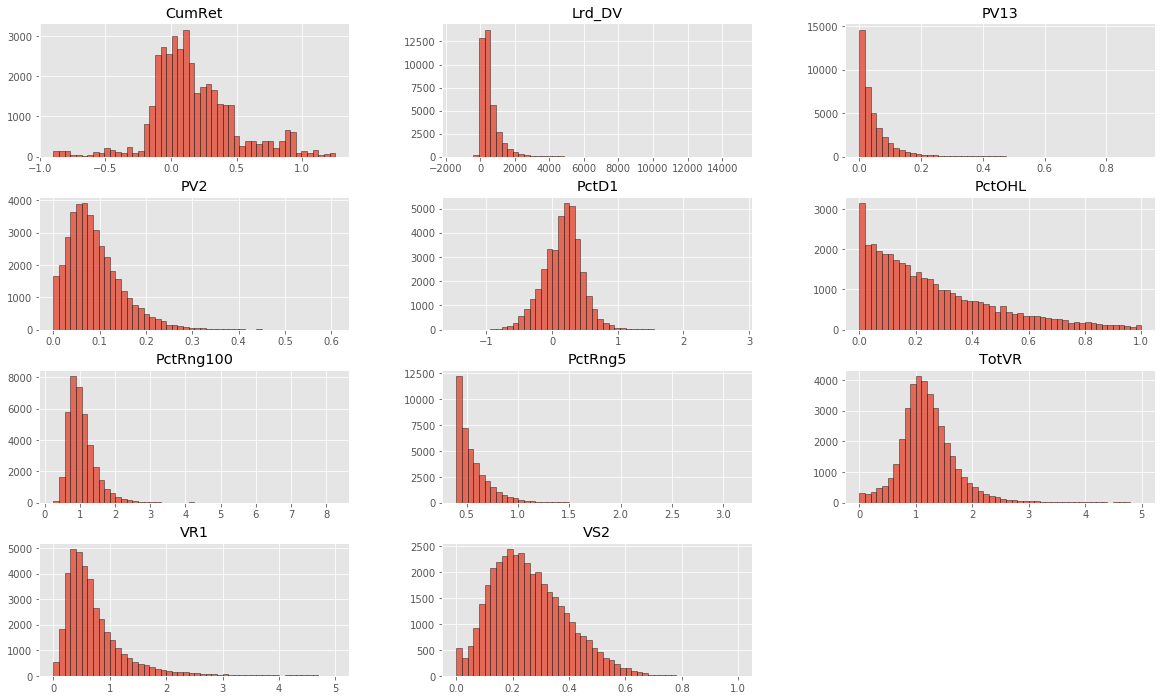

In [10]:
X_train.hist(bins=50,alpha=0.8,edgecolor='black', figsize=(20,12));

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="box cox">
## Box Cox transformation of features
<hr>

In [11]:
#Estimate Box Cox on train set, apply to test set
def transform_features(x_train, x_test):
            
    _, n_feats = x_train.shape

    x_train_boxcox = np.zeros(x_train.shape)
    lmbda_opt = np.zeros((n_feats,))

    eps = 1.0  # shift features away from zero
    for i in range(n_feats):
        x_train_boxcox[:, i], lmbda_opt[i] = boxcox(x_train[:, i] + eps)

    x_test_boxcox = np.zeros(x_test.shape)
    for i in range(n_feats):
        x_test_boxcox[:, i] = boxcox(x_test[:, i] + eps, lmbda=lmbda_opt[i])

    return x_train_boxcox, x_test_boxcox 

In [12]:
# First, need to apply [0,1] transformation since Box Cox can't deal with negative numbers
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [13]:
X_train_bcox, X_test_bcox = transform_features(X_train_sc, X_test_sc)

In [14]:
X_train_bcox.shape

(38709, 11)

In [15]:
X_test_bcox.shape

(15565, 11)

### We're adding <code style="color:steelblue"> _bcox <code> columns to raw columns so we can test classification performance with both

In [16]:
cols = X_train.columns
for col in range(X_train_bcox.shape[1]):
    X_train[cols[col]+'_bcox'] = X_train_bcox[:,col]

In [17]:
cols = X_test.columns
for col in range(X_test_bcox.shape[1]):
    X_test[cols[col]+'_bcox'] = X_test_bcox[:,col]

In [18]:
X_train.head()

,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,VS2,PV13,VR1,...,PV2_bcox,PctD1_bcox,CumRet_bcox,TotVR_bcox,PctRng100_bcox,PctOHL_bcox,VS2_bcox,PV13_bcox,VR1_bcox,Lrd_DV_bcox
Date,,,,,,,,,,,,,,,,,,,,,
2004-03-31,0.566845,0.012197,0.475936,-0.003963,1.201205,1.218531,0.009434,0.349497,0.096541,0.270306,...,0.019019,0.458133,0.357280,0.176496,0.069945,0.009287,0.251720,0.052710,0.044377,0.038029
2004-04-06,0.513514,0.095890,0.130631,0.000789,0.904435,1.278744,0.149123,0.443065,0.008476,0.565409,...,0.110280,0.375328,0.358934,0.142481,0.072130,0.118617,0.296856,0.008642,0.077064,0.037723
2004-04-07,0.412429,0.020684,0.129944,0.002133,0.659084,0.811833,0.589041,0.147982,0.202630,0.750645,...,0.031212,0.375164,0.359401,0.110331,0.050319,0.282482,0.126710,0.064832,0.091807,0.038433
2004-04-21,0.425856,0.032548,-0.311787,0.018749,1.225677,1.179071,0.455357,0.064760,0.044511,2.091955,...,0.046921,0.269841,0.365164,0.179091,0.068428,0.249544,0.059766,0.034309,0.138044,0.040936
2004-04-22,0.418033,0.093742,-0.159836,0.013601,1.142937,1.068175,0.647059,0.444562,0.013363,0.276042,...,0.108585,0.305992,0.363381,0.170195,0.063769,0.294090,0.297526,0.013090,0.045150,0.039036


In [19]:
X_test.head()

,PctRng5,PV2,PctD1,CumRet,TotVR,PctRng100,PctOHL,VS2,PV13,VR1,...,PV2_bcox,PctD1_bcox,CumRet_bcox,TotVR_bcox,PctRng100_bcox,PctOHL_bcox,VS2_bcox,PV13_bcox,VR1_bcox,Lrd_DV_bcox
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.625000,0.082411,-0.275000,0.084319,0.720529,0.876885,0.346667,0.131323,0.032846,1.276875,...,0.099189,0.278585,0.387653,0.118763,0.054135,0.214234,0.114174,0.027609,0.118780,0.038632
2014-01-02,0.841667,0.029757,-0.058333,0.091375,0.827267,1.180872,0.257426,0.264228,0.035270,0.256933,...,0.043358,0.330187,0.390049,0.132795,0.068499,0.177222,0.204157,0.029108,0.042552,0.038988
2014-01-03,0.950000,0.208139,0.458333,0.088207,1.483945,1.328981,0.192982,0.364446,0.017262,0.888793,...,0.171607,0.453903,0.388974,0.204751,0.073840,0.144501,0.259388,0.016385,0.100695,0.035785
2014-01-07,0.440000,0.015391,0.234286,0.084271,1.282796,0.902379,0.064935,0.449544,0.015324,0.139223,...,0.023707,0.400143,0.387636,0.185032,0.055550,0.058493,0.299745,0.014774,0.024878,0.037934
2014-01-10,0.905109,0.058915,0.635036,0.079087,1.992749,1.478479,0.137097,0.089753,0.049972,0.783495,...,0.077013,0.496419,0.385873,0.247417,0.078382,0.110928,0.081051,0.037033,0.094066,0.040996


In [20]:
bcox_cols = X_train.columns[X_train.columns.str.contains(pat='_bcox')]
X_train_bcox = X_train[bcox_cols]

<br>
### Histograms after transformation
<hr>

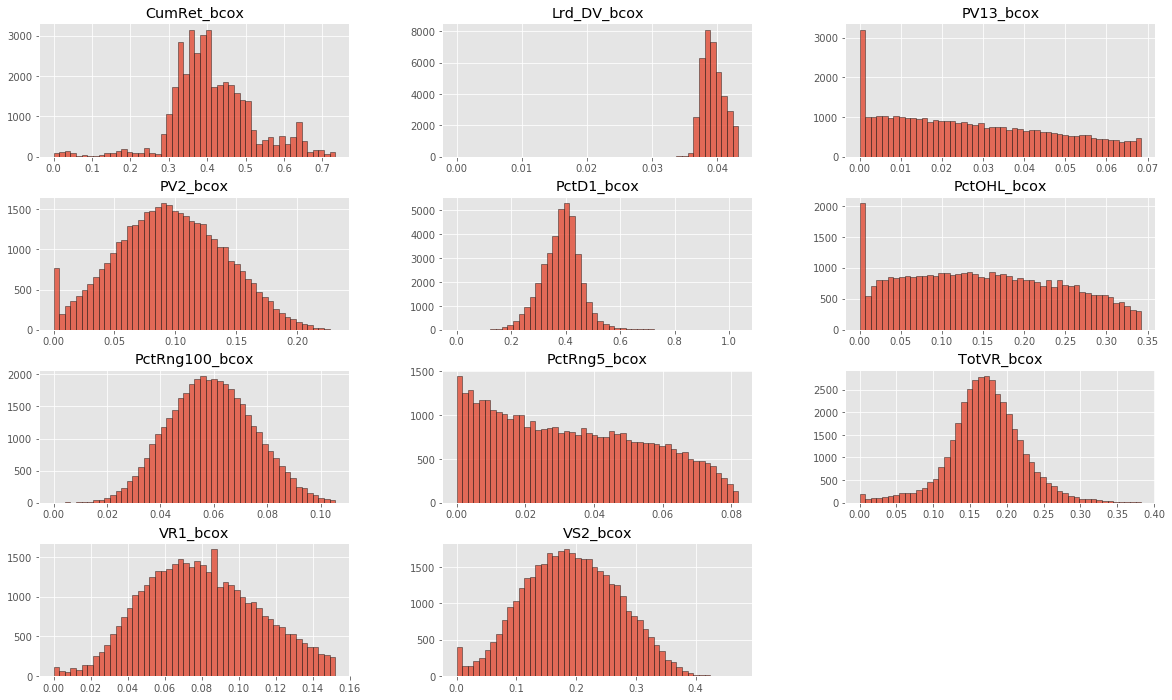

In [21]:
X_train_bcox.hist(bins=50,alpha=0.8,edgecolor='black', figsize=(20,12));

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="normality plots">
## Normal Probability Plots
<hr>

In [22]:
# Helper function for normality plot before and after transformation
def before_after_bcox(feat, feat_transf):    
    plt.subplots(1, 2, figsize=(14, 6))
    ax = plt.subplot(1, 2, 1)
    fig = stats.probplot(feat, plot=plt, fit=True, rvalue=True)
    ax.set_title(feat.name)

    ax = plt.subplot(1, 2, 2)
    fig = stats.probplot(feat_transf, plot=plt, fit=True, rvalue=True)
    ax.set_title(feat_transf.name)

    plt.suptitle('Normal Probability Plots Before/After Box Cox Transformation',fontsize=14)

    plt.show()

### Box Cox is not always successful but in our case every feature shows equal or higher R squared, suggesting smaller deviation from normal distribution than existed before transformation
<hr>

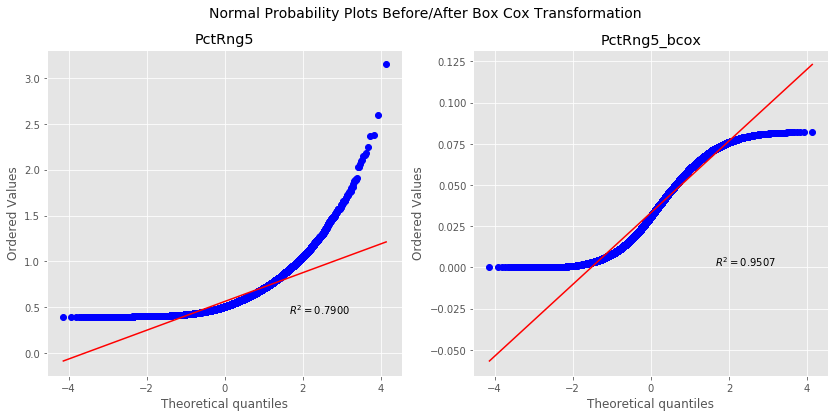

In [23]:
before_after_bcox(X_train.PctRng5, X_train.PctRng5_bcox)

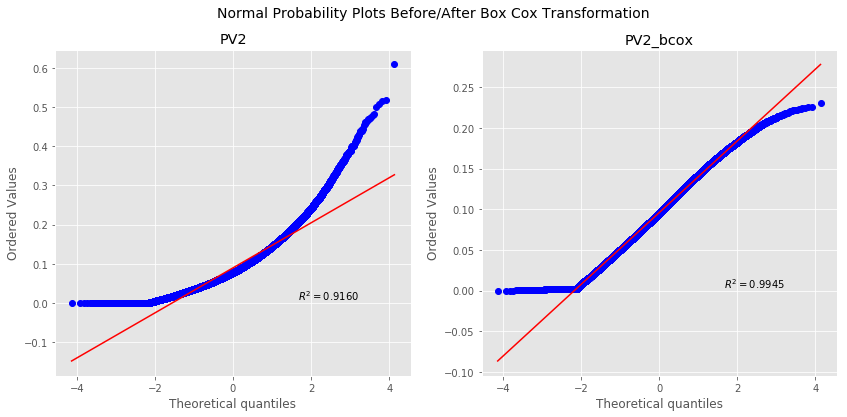

In [24]:
before_after_bcox(X_train.PV2, X_train.PV2_bcox)

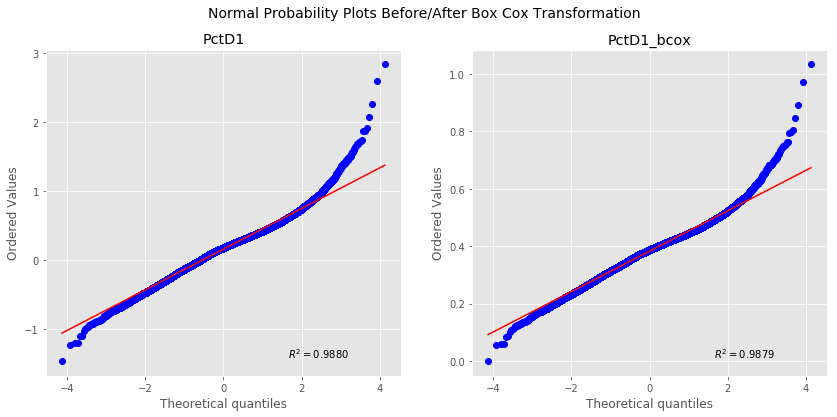

In [25]:
before_after_bcox(X_train.PctD1, X_train.PctD1_bcox)

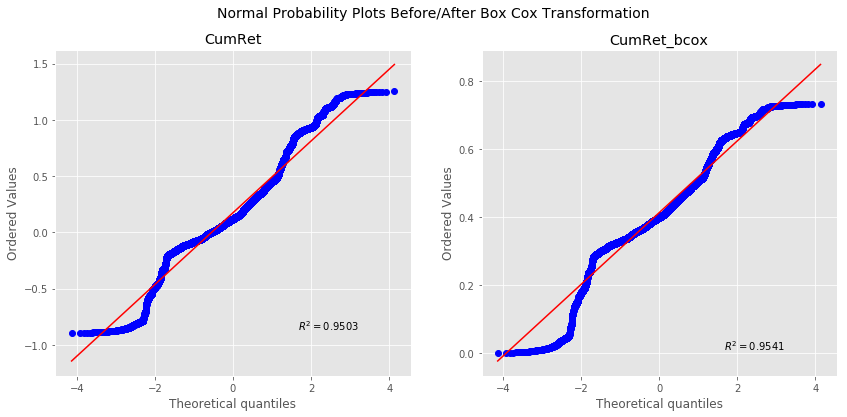

In [26]:
before_after_bcox(X_train.CumRet, X_train.CumRet_bcox)

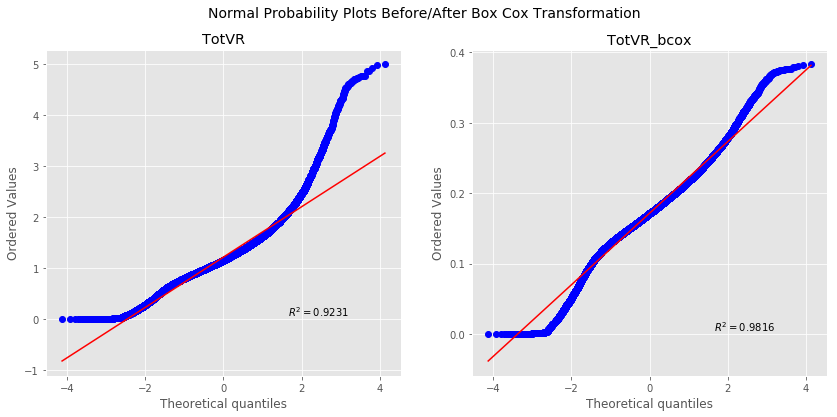

In [27]:
before_after_bcox(X_train.TotVR, X_train.TotVR_bcox)

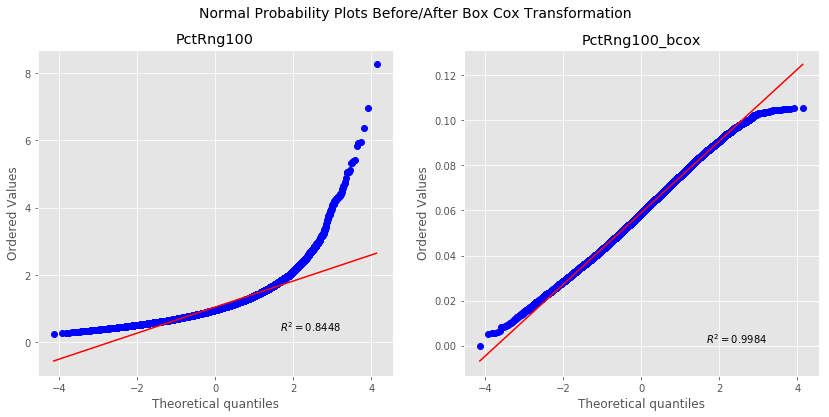

In [28]:
before_after_bcox(X_train.PctRng100, X_train.PctRng100_bcox)

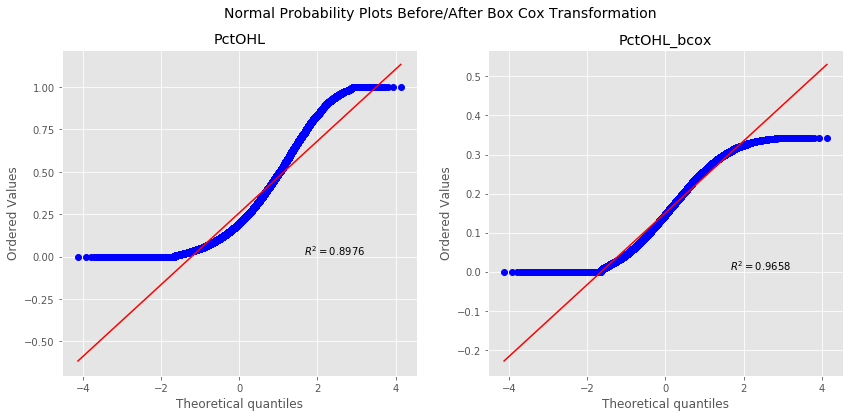

In [29]:
before_after_bcox(X_train.PctOHL, X_train.PctOHL_bcox)

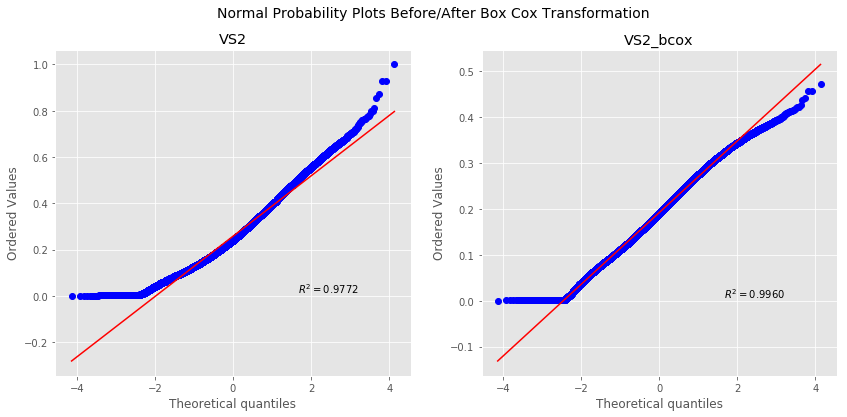

In [30]:
before_after_bcox(X_train.VS2, X_train.VS2_bcox)

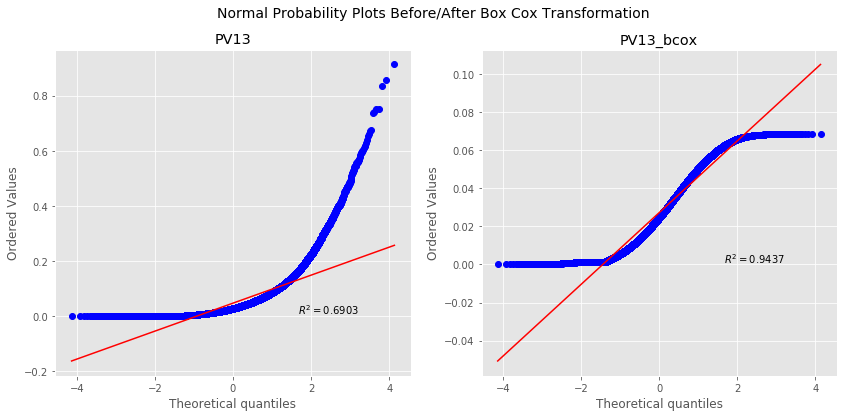

In [31]:
before_after_bcox(X_train.PV13, X_train.PV13_bcox)

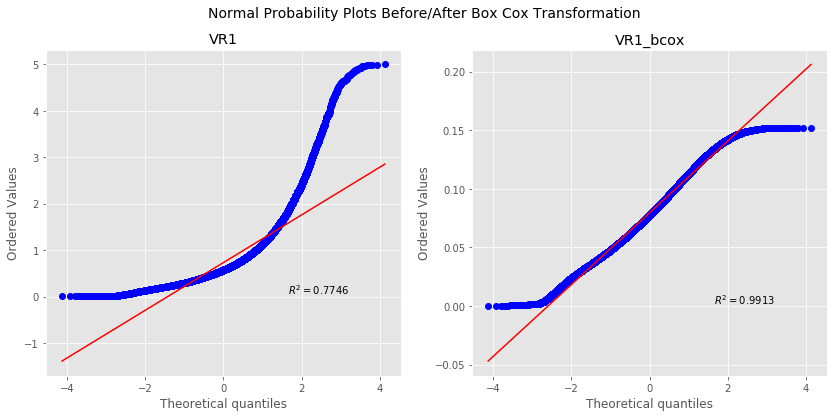

In [32]:
before_after_bcox(X_train.VR1, X_train.VR1_bcox)

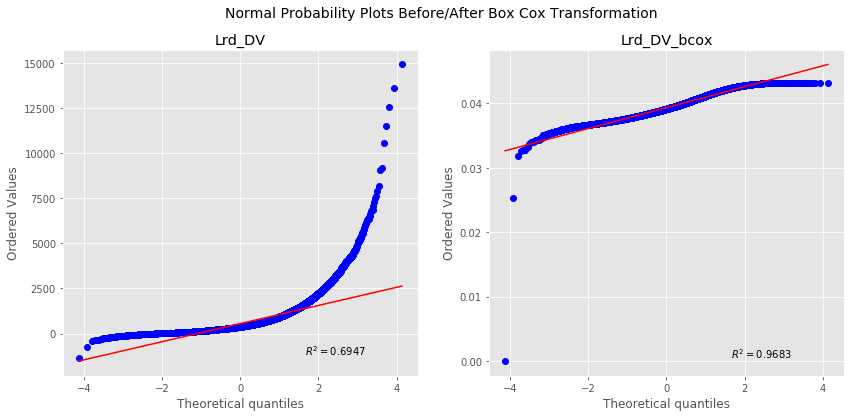

In [33]:
before_after_bcox(X_train.Lrd_DV, X_train.Lrd_DV_bcox)

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="save datasets">
## Save analytical base table for modeling
<hr>

In [34]:
X_train.to_csv('X_train.csv')

In [35]:
X_test.to_csv('X_test.csv')

In [36]:
y_train.to_csv('Y_train.csv', index=None)

In [37]:
y_test.to_csv('Y_test.csv', index=None)

In [38]:
sect_sym_ret = reduced_dim[['Date','Sector','Sym','PctRet']]
sect_sym_ret.set_index('Date',inplace=True)
split_date = pd.datetime(2013,12,31)
sect_sym_ret = sect_sym_ret.loc[sect_sym_ret.index> split_date]

sect_sym_ret.head()

,Sector,Sym,PctRet
Date,,,
2014-01-02,FX,AD,0.007056
2014-01-02,FX,AD,-0.003168
2014-01-03,FX,AD,-0.003936
2014-01-07,FX,AD,-0.005184
2014-01-10,FX,AD,0.002304


In [39]:
sect_sym_ret.to_csv('sector_sym_prcRet.csv')